In [2]:
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit.visualization import plot_histogram

## Creating Quantum Circuit

We begin by entangling the two qubits to create a Bell State $|\Phi^+\rangle$ = $\frac{|00\rangle+|11\rangle}{\sqrt{2}}$.

In [3]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.barrier()

Next we manuelly decide what message we want to send. Then depending on what that message is we apply certain quantum gates to encode our message in qubit 0.

Once the message is encoded a CNOT and H gate are applied to qubit 0. This is to ensure that our message is encoded in the final quantum statevector of the circuit. Meaning, after these gates we have some quantum state $|\text{message}\rangle$.

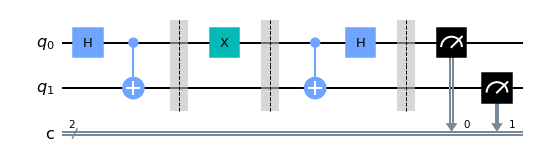

In [5]:
msg = '01'
if msg == '00':
    qc.barrier()
elif msg == '01':
    qc.x(0)
    qc.barrier()
elif msg == '10':
    qc.z(0)
    qc.barrier()
elif msg == '11':
    qc.z(0)
    qc.x(0)
    qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure(range(2),range(2))
qc.draw('mpl')

## Running Quantum Circuit

Running the circuit on the noisless simulator we see that we always measure the chosen message. This is because once we encode it in the quantum state we are guaranteed to measure qubit 0 and qubit 1 in the correct components of the message.

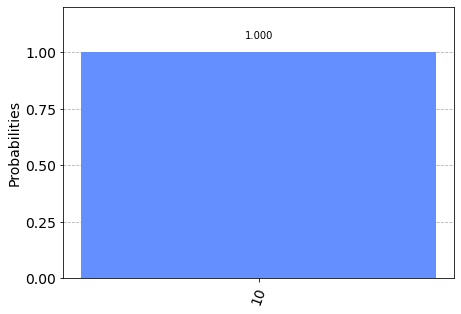

In [7]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(job_sim)

## Running on Real Quantum Hardware

When running on real hardware start by connecting to the IBM Quantum system.

In [8]:
from qiskit import IBMQ
provider = IBMQ.enable_account('API Token')
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='reczA7aZpklv6xtnQ')>]

After selecting a particular processor get its coupling map and backend properties.

In [9]:
import qiskit.tools.jupyter

device = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmq_santiago')
coupling_map = device.configuration().coupling_map
backend_properties = device.properties()

Use the coupling map and backend properties to create a noise model using the calibration of the selected processor. A noise model is useful for simulating noisy results without having to queue for the actual processor. We see that in this case sometimes we measure messages which are not the one we chose to send.

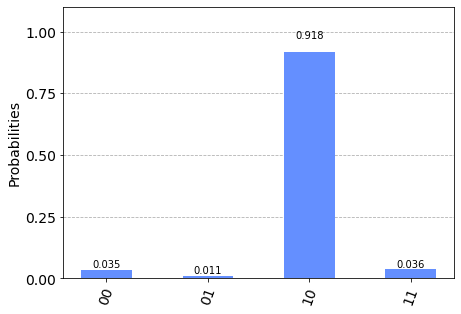

In [10]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import noise

# Creation of noise model and basis gate from backend properties

noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

bk = Aer.get_backend('qasm_simulator')
counts_noisy = execute(qc, shots=8192, backend=bk, coupling_map=coupling_map, 
                       basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts_noisy)

When moving on to running the circuit on the real device it's important to chose the same device which we created the noise model from. In this case the noise model and the real noisy results agree well.

In [ ]:
from qiskit.tools.monitor import job_monitor
bk_real = provider.get_backend('ibmq_santiago')
job_noisy_real = execute(qc, shots=8192, backend=bk_real)
job_monitor(job_noisy_real)

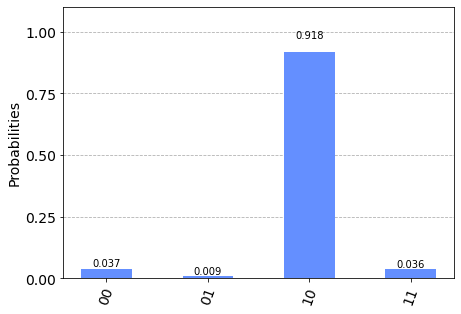

In [12]:
results_noisy_real = job_noisy_real.result()
counts_noisy_real = results_noisy_real.get_counts()
plot_histogram(counts_noisy_real)